In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import simps
from numpy import trapz


## Load Calibration Datasets

Data was taken from the graph in the [AS7341 datasheet](https://ams.com/documents/20143/36005/AS7341_DS000504_3-00.pdf/5eca1f59-46e2-6fc5-daf5-d71ad90c9b2b). First a screenshot was taken of the white LED spectrum's graph, then it was uploaded to [WebPlotDigitizer](https://apps.automeris.io/wpd/) and quantified.

### Load relative maximums

AGAIN: 256X except CLEAR (512X) and NIR (64X)

In [2]:
rel_max = pd.read_csv("relative_max.csv")
rel_max = rel_max.iloc[1:]
rel_max.columns = ["channel", "rel_max"]
rel_max.channel = ["415", "445", "480", "515", "555", "590", "630", "680", "NIR", "CLEAR"]
rel_max.rel_max = rel_max.rel_max.astype(float)

# Compensate for different gains
rel_max.loc[rel_max.channel == "NIR", "rel_max"] = rel_max.loc[rel_max.channel == "NIR", "rel_max"] * 4
rel_max.loc[rel_max.channel == "CLEAR", "rel_max"] = rel_max.loc[rel_max.channel == "CLEAR", "rel_max"] / 2
rel_max

,channel,rel_max
1,415,0.166387
2,445,0.303641
3,480,0.379272
4,515,0.485714
5,555,0.586555
6,590,0.653782
7,630,0.760224
8,680,0.998319
9,NIR,1.606723
10,CLEAR,0.441737


### Read dataset of relative sensitivity for each channel

Relative Irradiance Responsivity: uW / cm2

In [55]:
df_ch_sensitivity = pd.read_csv("ch_sensitivity.csv")
df_ch_sensitivity = df_ch_sensitivity.drop([0], axis=0)

master_df = pd.DataFrame()
master_df["wavelength"] = range(0, 1500)
master_df.set_index("wavelength")

dfs = {}
for i, data_type in enumerate(["415", "445", "480", "515", "555", "590", "630", "680", "NIR", "CLEAR"]):
    # Read raw data as floats
    x_data = df_ch_sensitivity[data_type].astype(float)
    y_data = df_ch_sensitivity[f"Unnamed: {2 * i + 1}"].astype(float)

    # Find min and max values of X in raw data
    x_min = int(x_data.astype(float).min())
    x_max = int(x_data.astype(float).max())

    # Create new X values (every integer between min and max), and interpolate new Y values
    x_int = list(range(x_min, x_max))
    y_int = np.interp(x_int, x_data, y_data)

    dfs[data_type] = pd.DataFrame()
    dfs[data_type]["wavelength"] = x_int
    dfs[data_type]["intensity"] = y_int
    
    # Scale with relative maximums
    scaled_y = dfs[data_type].intensity.apply(lambda intensity: intensity * rel_max.loc[rel_max.channel == data_type, "rel_max"])
    dfs[data_type].intensity = scaled_y

    for i, row in dfs[data_type].iterrows():
        master_df.loc[row.wavelength, data_type] = row.intensity

<AxesSubplot:xlabel='wavelength'>

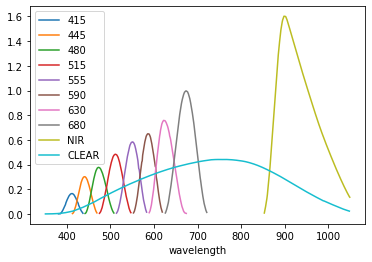

In [44]:
master_df.plot(x="wavelength")

## Get channel bounds

In [110]:
channels = {
415: 26,
445: 30,
480: 36,
515: 39,
555: 39,
590: 40,
630: 50,
680: 52
}

channel_bounds = {}
for mid in channels:
    channel_bounds[mid] = (mid - channels[mid] / 2, mid + channels[mid] / 2, )
channel_bounds

{415: (402.0, 428.0),
 445: (430.0, 460.0),
 480: (462.0, 498.0),
 515: (495.5, 534.5),
 555: (535.5, 574.5),
 590: (570.0, 610.0),
 630: (605.0, 655.0),
 680: (654.0, 706.0)}

In [185]:
def get_abs_spectrum(irradiance_uW_per_cm2, rel_sensitivity_filename):
    spectrum = pd.read_csv(rel_sensitivity_filename, header=None)
    spectrum.columns = ["wavelength", "intensity"]

    spectrum = spectrum.sort_values(by="wavelength")

    # Create integer values for X axis, then interpolate Y values for the new X values
    x_int = list(range(int(spectrum.wavelength.min()), int(spectrum.wavelength.max())))
    y_int = np.interp(x_int, spectrum.wavelength, spectrum.intensity)

    spectrum = pd.DataFrame()
    spectrum["wavelength"] = x_int
    spectrum["intensity"] = y_int

    # Get absolute power of wavelength bands in Watts per m2
    irradiance_W_per_cm2 = irradiance_uW_per_cm2 / 1e6
    irradiance_W_per_m2 = irradiance_W_per_cm2 * 100 * 100
    sum_rel_int = spectrum.intensity.sum()
    spectrum["power_W_per_m2"] = irradiance_W_per_m2 * (spectrum.intensity / sum_rel_int)

    # Get photon count per second per cm2
    h = 6.6260695e-34
    c = 299792458
    spectrum["photon_energy_joules"] = h * c / (spectrum.wavelength * 1e-9)
    spectrum["photon_count_per_m2_per_s"] = spectrum.power_W_per_m2 / spectrum.photon_energy_joules

    # Get total photon amount (mol / m2 / s)
    spectrum["photon_amount_mols_per_m2_per_s"] = spectrum.photon_count_per_m2_per_s / 6e23

    return spectrum[["wavelength", "photon_amount_mols_per_m2_per_s"]]


## White LED

Irradiance of calibration light source: 107.67μW/cm²

### Relative energy of wavelength bands

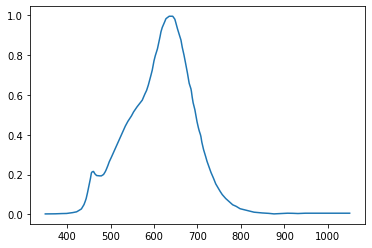

In [101]:
white_spectrum = pd.read_csv("white_spectrum.csv", header=None)
white_spectrum.columns = ["wavelength", "intensity"]

# Create integer values for X axis, then interpolate Y values for the new X values
x_int_white = list(range(350, 1051))
y_int_white = np.interp(x_int_white, white_spectrum.wavelength, white_spectrum.intensity)

white_spectrum = pd.DataFrame()
white_spectrum["wavelength"] = x_int_white
white_spectrum["intensity"] = y_int_white

plt.plot(white_spectrum.wavelength, white_spectrum.intensity)
plt.show()

### Absolute energy of wavelength bands in Watts per m2

Sum:  0.00010766999999999998 W


<AxesSubplot:xlabel='wavelength'>

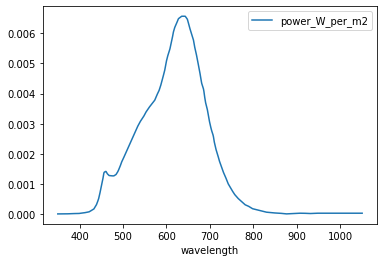

In [150]:
sum_rel_int = white_spectrum.intensity.sum()
irradiance_uW_per_cm2 = 107.67
irradiance_W_per_cm2 = irradiance_uW_per_cm2 / 1e6
irradiance_W_per_m2 = irradiance_W_per_cm2 * 100 * 100
white_spectrum["power_W_per_m2"] = irradiance_W_per_m2 * (white_spectrum.intensity / sum_rel_int)
print("Sum: ", white_spectrum["power"].sum(), "W")
white_spectrum.plot(x="wavelength", y="power_W_per_m2")

### Photon count per second per m2

![Picture title](image-20210513-223244.png)

<AxesSubplot:xlabel='wavelength'>

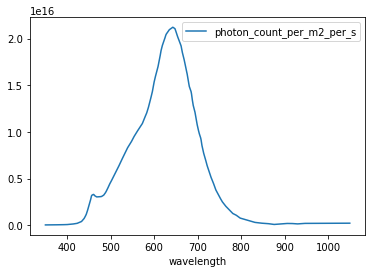

In [152]:
h = 6.6260695e-34
c = 299792458
white_spectrum["photon_energy_joules"] = h * c / (white_spectrum.wavelength * 1e-9)
white_spectrum["photon_count_per_m2_per_s"] = white_spectrum.power_W_per_m2 / white_spectrum.photon_energy_joules
white_spectrum.plot(x="wavelength", y="photon_count_per_m2_per_s")

### Get total photon amount (mol / m2 / s)

<AxesSubplot:xlabel='wavelength'>

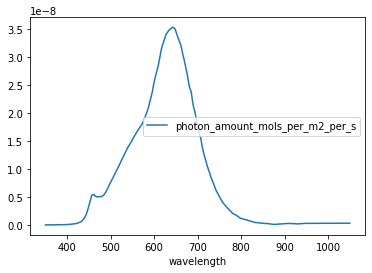

In [153]:
white_spectrum["photon_amount_mols_per_m2_per_s"] = white_spectrum.photon_count_per_m2_per_s / 6e23
white_spectrum.plot(x="wavelength", y="photon_amount_mols_per_m2_per_s")

<AxesSubplot:xlabel='wavelength'>

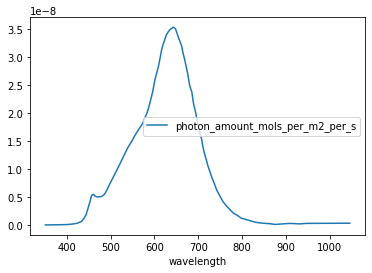

In [180]:
white_spectrum_df = get_abs_spectrum(107.67, "white_spectrum.csv")
white_spectrum_df.plot(x="wavelength", y="photon_amount_mols_per_m2_per_s")

In [159]:
white_spectrum_df.photon_amount_mols_per_m2_per_s.sum()

5.574184104880176e-06

### Get photon amount per channel (mol / m2 / s)

In [164]:
amounts_per_channel = {}
for ch_mid in channel_bounds:
    ch_min = int(channel_bounds[ch_mid][0])
    ch_max = int(channel_bounds[ch_mid][1])
    amounts_per_channel[ch_mid] = white_spectrum_df.photon_amount_mols_per_m2_per_s.iloc[ch_min:ch_max].sum()
amounts_per_channel

{415: 9.083962067860048e-08,
 445: 4.536767396626559e-08,
 480: 2.111655528174177e-08,
 515: 9.78609565960948e-09,
 555: 1.0843511009700743e-08,
 590: 1.162846722259386e-08,
 630: 1.676256493321131e-08,
 680: 1.6520923874653942e-08}

### Get final calibration factor: mol / m2 / s per sensor count

In [165]:
standard_sensor_counts = {
    415: 55,
    445: 110,
    480: 210,
    515: 390,
    555: 590,
    590: 840,
    630: 1350,
    680: 1070
}

micromol_per_counts = {}
for ch in standard_sensor_counts:
    micromol_per_counts[ch] = amounts_per_channel[ch] / standard_sensor_counts[ch]
micromol_per_counts

{415: 1.6516294668836452e-09,
 445: 4.1243339969332355e-10,
 480: 1.0055502515115129e-10,
 515: 2.509255297335764e-11,
 555: 1.8378832219831768e-11,
 590: 1.3843413360230785e-11,
 630: 1.241671476534171e-11,
 680: 1.544011577070462e-11}

### Get daily light integral per m2

In [ ]:
counts_per_m2_s * 60 * 60 * 24

0.4831402093981928

### Blue LED

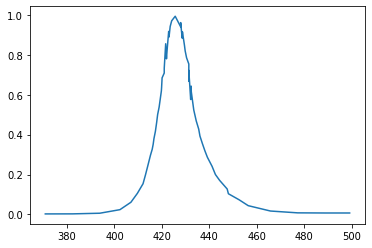

In [183]:
blue_spectrum = pd.read_csv("blue_spectrum.csv", header=None)
blue_spectrum.columns = ["wavelength", "intensity"]
blue_spectrum = blue_spectrum.sort_values(by="wavelength")

# Create integer values for X axis, then interpolate Y values for the new X values
x_int_blue = list(range(380, 501))
y_int_blue = np.interp(x_int_blue, blue_spectrum.wavelength, blue_spectrum.intensity)

blue_spectrum_int = pd.DataFrame()
blue_spectrum_int["wavelength"] = x_int_blue
blue_spectrum_int["intensity"] = y_int_blue

plt.plot(blue_spectrum.wavelength, blue_spectrum.intensity)
plt.show()

<AxesSubplot:xlabel='wavelength'>

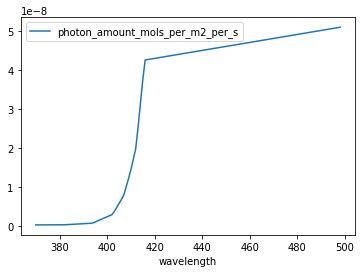

In [181]:
blue_spectrum_df = get_abs_spectrum(57, "blue_spectrum.csv")
blue_spectrum_df.plot(x="wavelength", y="photon_amount_mols_per_m2_per_s")

### Red LED

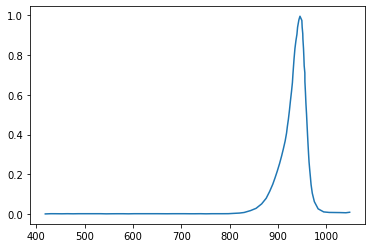

In [ ]:
red_spectrum = pd.read_csv("red_spectrum.csv", header=None)
red_spectrum.columns = ["wavelength", "intensity"]
red_spectrum = red_spectrum.sort_values(by="wavelength")

# Create integer values for X axis, then interpolate Y values for the new X values
x_int_red = list(range(400, 1051))
y_int_red = np.interp(x_int_red, red_spectrum.wavelength, red_spectrum.intensity)

red_spectrum_int = pd.DataFrame()
red_spectrum_int["wavelength"] = x_int_red
red_spectrum_int["intensity"] = y_int_red

plt.plot(red_spectrum.wavelength, red_spectrum.intensity)
plt.show()

<AxesSubplot:xlabel='wavelength'>

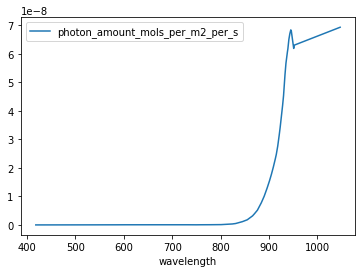

In [184]:
blue_spectrum_df = get_abs_spectrum(98, "red_spectrum.csv")
blue_spectrum_df.plot(x="wavelength", y="photon_amount_mols_per_m2_per_s")

### Plot LED spectrum vs. relative sensitivity

White LED vs. CLEAR channel

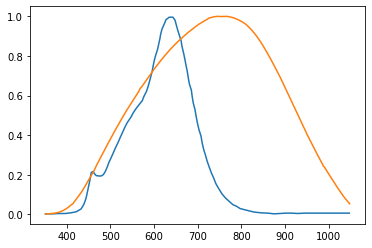

In [ ]:
plt.plot(white_spectrum.wavelength, white_spectrum.intensity, dfs["CLEAR"].wavelength, dfs["CLEAR"].intensity)
plt.show()

Blue LED vs. 415nm channel

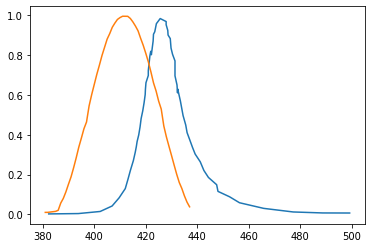

In [ ]:
plt.plot(blue_spectrum.wavelength, blue_spectrum.intensity, dfs["415"].wavelength, dfs["415"].intensity)
plt.show()

Red LED vs. NIR channel

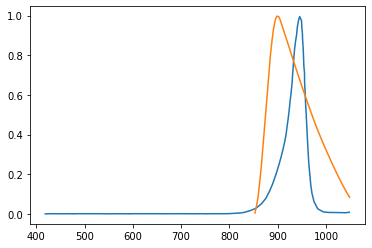

In [ ]:
plt.plot(red_spectrum.wavelength, red_spectrum.intensity, dfs["NIR"].wavelength, dfs["NIR"].intensity)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=855ecca9-cfde-49df-871b-8d5017416c31' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>